# Iterative Stratification Cross-validation Frames DS Classifier
##Iterative Stratification
Is a technique specifically designed for multi-label classification problems, which involves data points having more than one label. Unlike typical stratified cross-validation that maintains the distribution of labels in each fold, Iterative Stratification does this iteratively for every label combination to achieve a balanced distribution.
http://scikit.ml/api/skmultilearn.model_selection.iterative_stratification.html
##Maintains Label Distribution
In typical multi-label datasets, some labels may be more common, while others are rare. Iterative Stratification ensures that both the training and validation datasets have a similar distribution of each label, which is particularly important for underrepresented classes.

In [ ]:
import pandas as pd
import numpy as np
import torch
import os
import json
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, RobertaConfig, AdamW, get_scheduler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, hamming_loss
from torch.nn import BCEWithLogitsLoss
from torch.cuda.amp import autocast, GradScaler
from tqdm.auto import tqdm
from google.colab import drive
import matplotlib.pyplot as plt
from collections import Counter

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-multilearn
from skmultilearn.model_selection import IterativeStratification

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 5.2 MB/s eta 0:00:00


In [ ]:
# Check if GPU is available and set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

# Clear CUDA cache
torch.cuda.empty_cache()

file_path = '/content/drive/MyDrive/HCI Master courses/THESIS/frames_parsed.csv'
df = pd.read_csv(file_path)

# Handle NaN and ensure all entries are strings
df['DA'] = df['DA'].fillna('').astype(str)
df['context'] = df['context'].fillna('').astype(str)

# Preprocess the 'DA' column into multi-label format
dialogue_acts = df['DA'].str.split(', ')
mlb = MultiLabelBinarizer()
df_labels = mlb.fit_transform(dialogue_acts)

# Load tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
num_labels = df_labels.shape[1]
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)
model = model.to(device)  # Move model to the appropriate device


Using device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define custom dataset class

In [ ]:
class FramesDataset(Dataset):
    def __init__(self, dataframe, labels, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx]['context']
        labels = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.float)
        }

## IterativeStratification for cross-validation

In [ ]:
n_splits = 5
stratifier = IterativeStratification(n_splits=n_splits, order=1)

# Training parameters
num_epochs = 5
learning_rate = 2e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
scaler = GradScaler()
criterion = BCEWithLogitsLoss()

# Initialize lists to store training and validation losses, accuracies, and timing for each fold
all_train_losses = []
all_val_losses = []
all_accuracies = []

for split_idx, (train_index, test_index) in enumerate(stratifier.split(df, df_labels), start=1):
    train_df, test_df = df.iloc[train_index], df.iloc[test_index]
    train_labels, test_labels = df_labels[train_index], df_labels[test_index]

    # Create datasets and data loaders
    train_dataset = FramesDataset(train_df, train_labels, tokenizer)
    test_dataset = FramesDataset(test_df, test_labels, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Track losses, accuracies, and time for the current split
    train_losses = []
    val_losses = []
    accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1} (Split {split_idx})"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            with autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                loss = criterion(logits, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Average Training Loss for Epoch {epoch + 1} (Split {split_idx}): {avg_train_loss}")

        # Validation loop
        model.eval()
        total_val_loss = 0
        all_predictions, all_labels = [], []
        with torch.no_grad():
            for batch in tqdm(test_loader, desc=f"Validation Epoch {epoch + 1} (Split {split_idx})"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                loss = criterion(logits, labels)
                total_val_loss += loss.item()

                predictions = torch.sigmoid(logits).cpu().numpy()
                all_predictions.extend(predictions > 0.5)
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(test_loader)
        val_losses.append(avg_val_loss)
        print(f"Average Validation Loss for Epoch {epoch + 1} (Split {split_idx}): {avg_val_loss}")

        # Calculate accuracy for the current epoch
        accuracy = accuracy_score(np.array(all_labels), np.array(all_predictions))
        accuracies.append(accuracy)
        print(f"Validation Accuracy for Epoch {epoch + 1} (Split {split_idx}): {accuracy}")

    # Store losses, accuracies, and time for the current split
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_accuracies.append(accuracies)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-5-8452c3925f00>:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Training Epoch 1 (Split 1):   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-5-8452c3925f00>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Average Training Loss for Epoch 1 (Split 1): 0.13278438900969922


Validation Epoch 1 (Split 1):   0%|          | 0/250 [00:00<?, ?it/s]

Average Validation Loss for Epoch 1 (Split 1): 0.07734253880381584
Validation Accuracy for Epoch 1 (Split 1): 0.6480460921843687


Training Epoch 2 (Split 1):   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-5-8452c3925f00>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Average Training Loss for Epoch 2 (Split 1): 0.06742069971095771


Validation Epoch 2 (Split 1):   0%|          | 0/250 [00:00<?, ?it/s]

Average Validation Loss for Epoch 2 (Split 1): 0.06421042064577341
Validation Accuracy for Epoch 2 (Split 1): 0.6826152304609219


Training Epoch 3 (Split 1):   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-5-8452c3925f00>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Average Training Loss for Epoch 3 (Split 1): 0.053171088316477835


Validation Epoch 3 (Split 1):   0%|          | 0/250 [00:00<?, ?it/s]

Average Validation Loss for Epoch 3 (Split 1): 0.058569163858890536
Validation Accuracy for Epoch 3 (Split 1): 0.7061623246492986


Training Epoch 4 (Split 1):   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-5-8452c3925f00>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Average Training Loss for Epoch 4 (Split 1): 0.04411382964719087


Validation Epoch 4 (Split 1):   0%|          | 0/250 [00:00<?, ?it/s]

Average Validation Loss for Epoch 4 (Split 1): 0.05538801668584347
Validation Accuracy for Epoch 4 (Split 1): 0.7146793587174348


Training Epoch 5 (Split 1):   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-5-8452c3925f00>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Average Training Loss for Epoch 5 (Split 1): 0.037078065081499516


Validation Epoch 5 (Split 1):   0%|          | 0/250 [00:00<?, ?it/s]

Average Validation Loss for Epoch 5 (Split 1): 0.05751845211535692
Validation Accuracy for Epoch 5 (Split 1): 0.7039078156312625


Training Epoch 1 (Split 2):   0%|          | 0/999 [00:00<?, ?it/s]

<ipython-input-5-8452c3925f00>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Average Training Loss for Epoch 1 (Split 2): 0.039415339308625855


Validation Epoch 1 (Split 2):   0%|          | 0/251 [00:00<?, ?it/s]

Average Validation Loss for Epoch 1 (Split 2): 0.028578976308370373
Validation Accuracy for Epoch 1 (Split 2): 0.8399500624219726


Training Epoch 2 (Split 2):   0%|          | 0/999 [00:00<?, ?it/s]

<ipython-input-5-8452c3925f00>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Average Training Loss for Epoch 2 (Split 2): 0.032392947532299966


Validation Epoch 2 (Split 2):   0%|          | 0/251 [00:00<?, ?it/s]

Average Validation Loss for Epoch 2 (Split 2): 0.030671764790373614
Validation Accuracy for Epoch 2 (Split 2): 0.8242197253433209


Training Epoch 3 (Split 2):   0%|          | 0/999 [00:00<?, ?it/s]

<ipython-input-5-8452c3925f00>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Average Training Loss for Epoch 3 (Split 2): 0.02824597632711953


Validation Epoch 3 (Split 2):   0%|          | 0/251 [00:00<?, ?it/s]

Average Validation Loss for Epoch 3 (Split 2): 0.03080189446603278
Validation Accuracy for Epoch 3 (Split 2): 0.8302122347066168


Training Epoch 4 (Split 2):   0%|          | 0/999 [00:00<?, ?it/s]

<ipython-input-5-8452c3925f00>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Average Training Loss for Epoch 4 (Split 2): 0.023846420153902773


Validation Epoch 4 (Split 2):   0%|          | 0/251 [00:00<?, ?it/s]

Average Validation Loss for Epoch 4 (Split 2): 0.03339369167792666
Validation Accuracy for Epoch 4 (Split 2): 0.8107365792759051


Training Epoch 5 (Split 2):   0%|          | 0/999 [00:00<?, ?it/s]

<ipython-input-5-8452c3925f00>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Average Training Loss for Epoch 5 (Split 2): 0.021514583688072703


Validation Epoch 5 (Split 2):   0%|          | 0/251 [00:00<?, ?it/s]

Average Validation Loss for Epoch 5 (Split 2): 0.0346054480433375
Validation Accuracy for Epoch 5 (Split 2): 0.8099875156054931


Training Epoch 1 (Split 3):   0%|          | 0/1001 [00:00<?, ?it/s]

<ipython-input-5-8452c3925f00>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Average Training Loss for Epoch 1 (Split 3): 0.024149276272902687


Validation Epoch 1 (Split 3):   0%|          | 0/249 [00:00<?, ?it/s]

Average Validation Loss for Epoch 1 (Split 3): 0.01669395143113821
Validation Accuracy for Epoch 1 (Split 3): 0.9097536450477627


Training Epoch 2 (Split 3):   0%|          | 0/1001 [00:00<?, ?it/s]

<ipython-input-5-8452c3925f00>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Average Training Loss for Epoch 2 (Split 3): 0.019825907270112388


Validation Epoch 2 (Split 3):   0%|          | 0/249 [00:00<?, ?it/s]

Average Validation Loss for Epoch 2 (Split 3): 0.017010886385760093
Validation Accuracy for Epoch 2 (Split 3): 0.9009552538964304


Training Epoch 3 (Split 3):   0%|          | 0/1001 [00:00<?, ?it/s]

<ipython-input-5-8452c3925f00>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Average Training Loss for Epoch 3 (Split 3): 0.017174819147667393


Validation Epoch 3 (Split 3):   0%|          | 0/249 [00:00<?, ?it/s]

Average Validation Loss for Epoch 3 (Split 3): 0.017535526867877377
Validation Accuracy for Epoch 3 (Split 3): 0.8976872800402212


Training Epoch 4 (Split 3):   0%|          | 0/1001 [00:00<?, ?it/s]

<ipython-input-5-8452c3925f00>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Average Training Loss for Epoch 4 (Split 3): 0.015310823681650796


Validation Epoch 4 (Split 3):   0%|          | 0/249 [00:00<?, ?it/s]

Average Validation Loss for Epoch 4 (Split 3): 0.017960553283309453
Validation Accuracy for Epoch 4 (Split 3): 0.8989441930618401


Training Epoch 5 (Split 3):   0%|          | 0/1001 [00:00<?, ?it/s]

<ipython-input-5-8452c3925f00>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Average Training Loss for Epoch 5 (Split 3): 0.013509079050686728


Validation Epoch 5 (Split 3):   0%|          | 0/249 [00:00<?, ?it/s]

Average Validation Loss for Epoch 5 (Split 3): 0.020554535762298418
Validation Accuracy for Epoch 5 (Split 3): 0.8836098541980895


Training Epoch 1 (Split 4):   0%|          | 0/998 [00:00<?, ?it/s]

<ipython-input-5-8452c3925f00>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Average Training Loss for Epoch 1 (Split 4): 0.016421321471653812


Validation Epoch 1 (Split 4):   0%|          | 0/252 [00:00<?, ?it/s]

Average Validation Loss for Epoch 1 (Split 4): 0.00915533462945845
Validation Accuracy for Epoch 1 (Split 4): 0.9479037459687423


Training Epoch 2 (Split 4):   0%|          | 0/998 [00:00<?, ?it/s]

<ipython-input-5-8452c3925f00>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Average Training Loss for Epoch 2 (Split 4): 0.013263714753074071


Validation Epoch 2 (Split 4):   0%|          | 0/252 [00:00<?, ?it/s]

Average Validation Loss for Epoch 2 (Split 4): 0.008944670371304725
Validation Accuracy for Epoch 2 (Split 4): 0.9491441329694865


Training Epoch 3 (Split 4):   0%|          | 0/998 [00:00<?, ?it/s]

<ipython-input-5-8452c3925f00>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Average Training Loss for Epoch 3 (Split 4): 0.011410802088464183


Validation Epoch 3 (Split 4):   0%|          | 0/252 [00:00<?, ?it/s]

Average Validation Loss for Epoch 3 (Split 4): 0.010563780139024842
Validation Accuracy for Epoch 3 (Split 4): 0.938476804763086


Training Epoch 4 (Split 4):   0%|          | 0/998 [00:00<?, ?it/s]

<ipython-input-5-8452c3925f00>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Average Training Loss for Epoch 4 (Split 4): 0.01081364062129014


Validation Epoch 4 (Split 4):   0%|          | 0/252 [00:00<?, ?it/s]

Average Validation Loss for Epoch 4 (Split 4): 0.010699380062370827
Validation Accuracy for Epoch 4 (Split 4): 0.9449268171669561


Training Epoch 5 (Split 4):   0%|          | 0/998 [00:00<?, ?it/s]

<ipython-input-5-8452c3925f00>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Average Training Loss for Epoch 5 (Split 4): 0.009839240848744673


Validation Epoch 5 (Split 4):   0%|          | 0/252 [00:00<?, ?it/s]

Average Validation Loss for Epoch 5 (Split 4): 0.011327729699486453
Validation Accuracy for Epoch 5 (Split 4): 0.9322748697593649


Training Epoch 1 (Split 5):   0%|          | 0/1001 [00:00<?, ?it/s]

<ipython-input-5-8452c3925f00>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Average Training Loss for Epoch 1 (Split 5): 0.01176286787223806


Validation Epoch 1 (Split 5):   0%|          | 0/249 [00:00<?, ?it/s]

Average Validation Loss for Epoch 1 (Split 5): 0.006170960717337079
Validation Accuracy for Epoch 1 (Split 5): 0.9711055276381909


Training Epoch 2 (Split 5):   0%|          | 0/1001 [00:00<?, ?it/s]

<ipython-input-5-8452c3925f00>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Average Training Loss for Epoch 2 (Split 5): 0.009781380167654757


Validation Epoch 2 (Split 5):   0%|          | 0/249 [00:00<?, ?it/s]

Average Validation Loss for Epoch 2 (Split 5): 0.0061859000989901705
Validation Accuracy for Epoch 2 (Split 5): 0.9711055276381909


Training Epoch 3 (Split 5):   0%|          | 0/1001 [00:00<?, ?it/s]

<ipython-input-5-8452c3925f00>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Average Training Loss for Epoch 3 (Split 5): 0.009227588620363873


Validation Epoch 3 (Split 5):   0%|          | 0/249 [00:00<?, ?it/s]

Average Validation Loss for Epoch 3 (Split 5): 0.006930759167495038
Validation Accuracy for Epoch 3 (Split 5): 0.9635678391959799


Training Epoch 4 (Split 5):   0%|          | 0/1001 [00:00<?, ?it/s]

<ipython-input-5-8452c3925f00>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Average Training Loss for Epoch 4 (Split 5): 0.008124803282114883


Validation Epoch 4 (Split 5):   0%|          | 0/249 [00:00<?, ?it/s]

Average Validation Loss for Epoch 4 (Split 5): 0.007632851221946528
Validation Accuracy for Epoch 4 (Split 5): 0.9608040201005025


Training Epoch 5 (Split 5):   0%|          | 0/1001 [00:00<?, ?it/s]

<ipython-input-5-8452c3925f00>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Average Training Loss for Epoch 5 (Split 5): 0.007799889481513408


Validation Epoch 5 (Split 5):   0%|          | 0/249 [00:00<?, ?it/s]

Average Validation Loss for Epoch 5 (Split 5): 0.008198272250779721
Validation Accuracy for Epoch 5 (Split 5): 0.9547738693467337


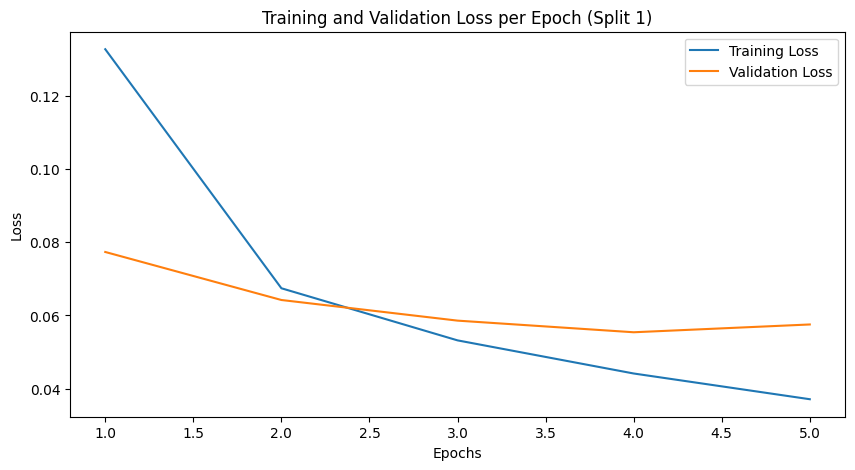

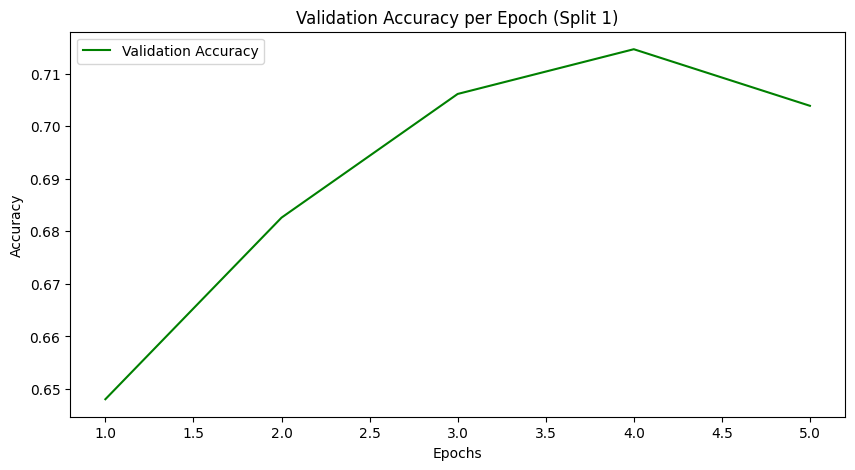

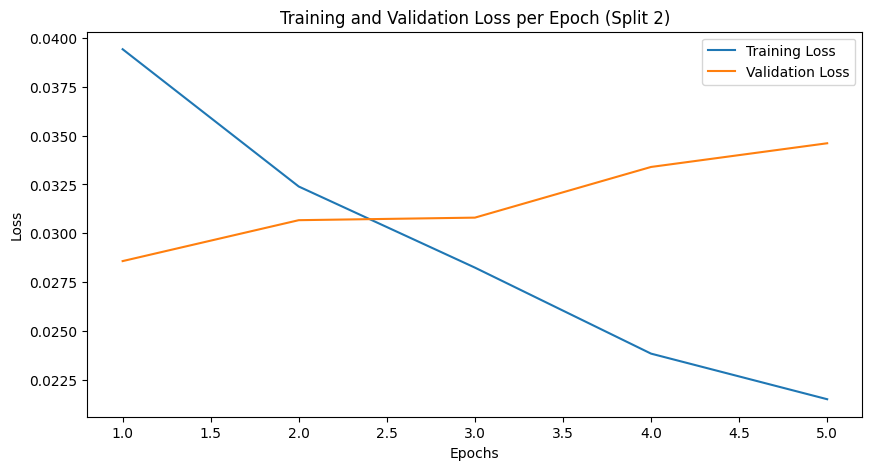

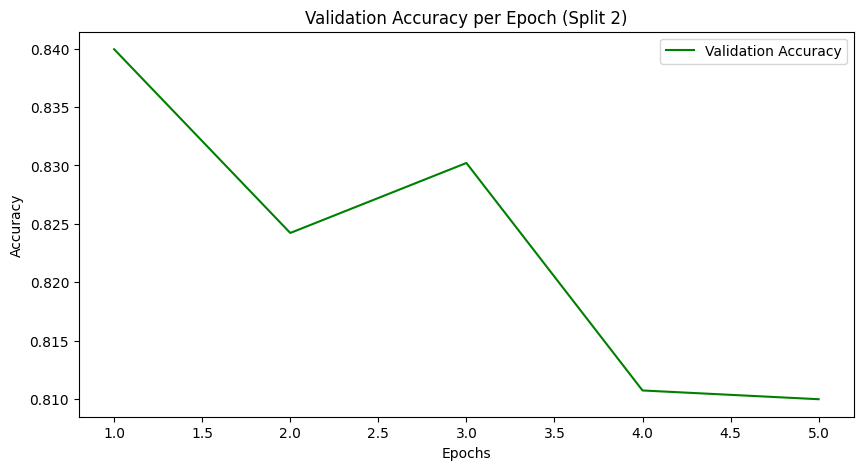

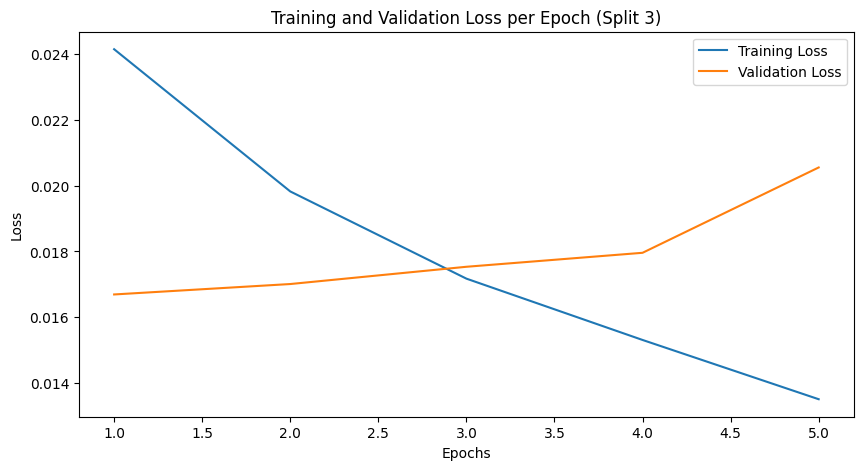

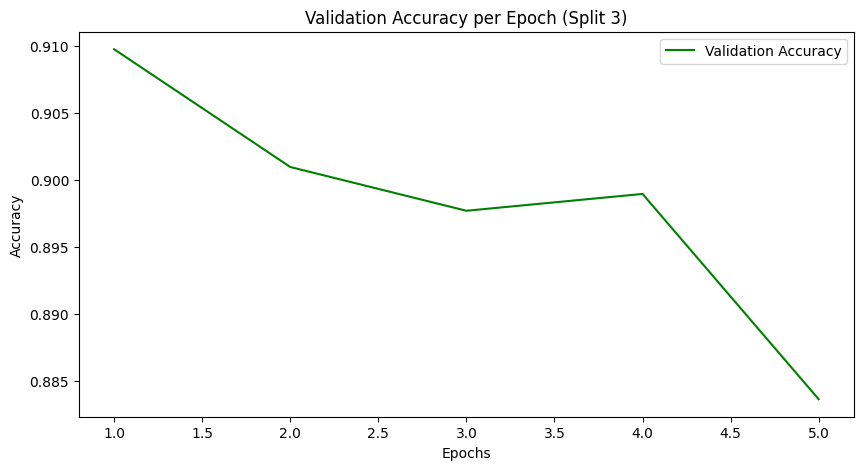

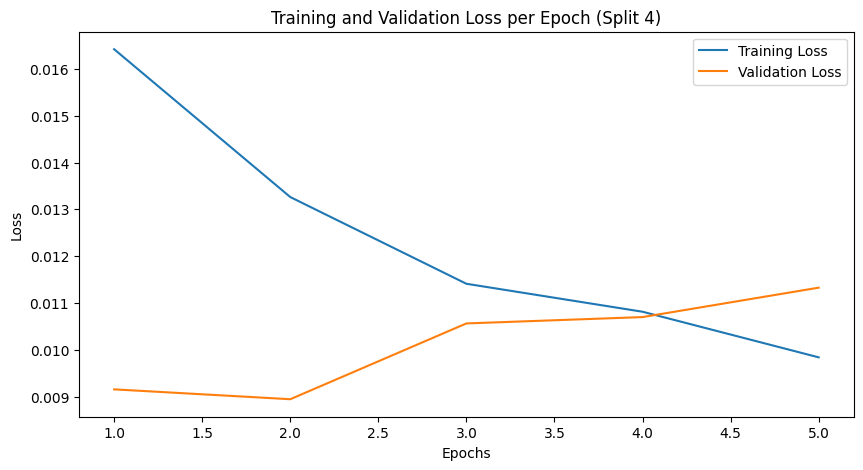

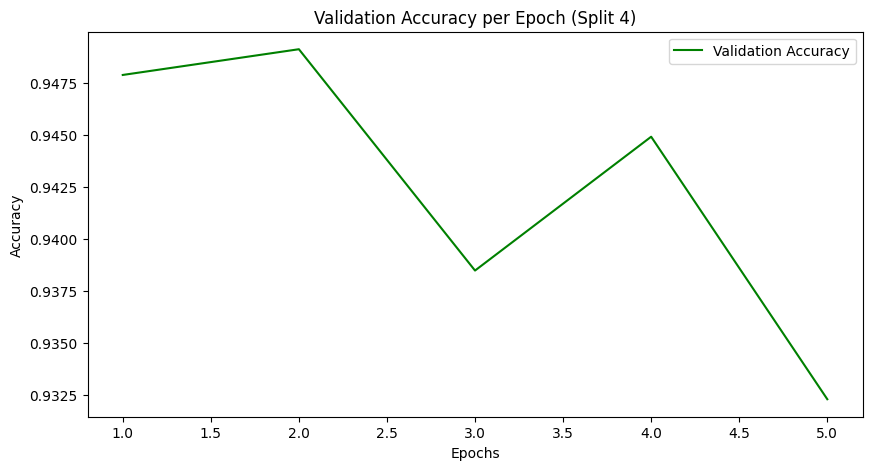

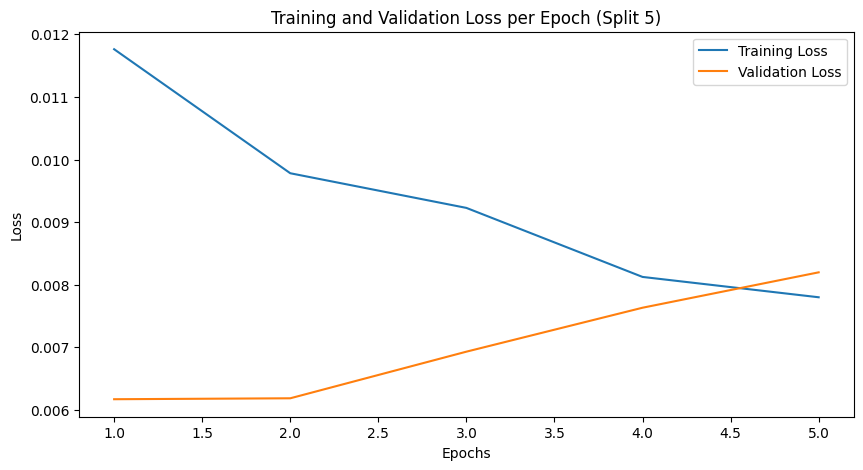

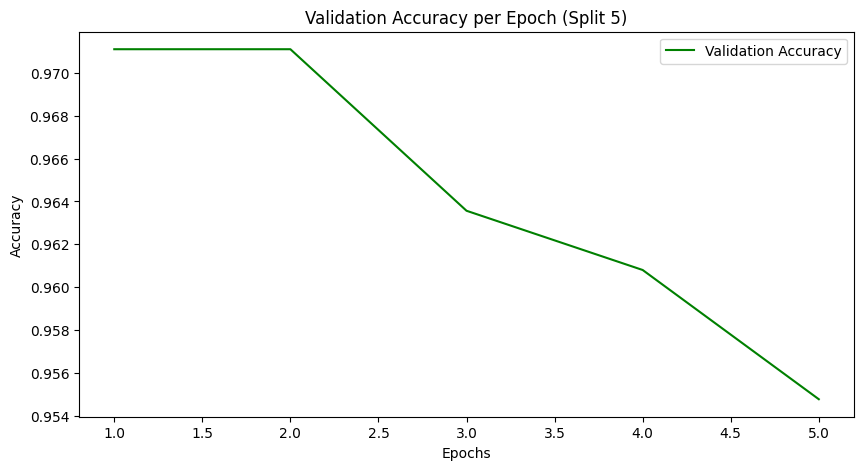

In [ ]:
for split_idx in range(n_splits):
    epochs_range = range(1, num_epochs + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, all_train_losses[split_idx], label='Training Loss')
    plt.plot(epochs_range, all_val_losses[split_idx], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss per Epoch (Split {split_idx + 1})')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, all_accuracies[split_idx], label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Validation Accuracy per Epoch (Split {split_idx + 1})')
    plt.legend()
    plt.show()